In [1]:
import joblib
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

font1 = {'family': 'Arial',
         'weight': 'regular',
         'size': 16,
         }

random_seed = 42

# Load data

In [2]:
data = pd.read_csv('dataset.csv')
data

,duration,current_median,current_mean,current_std,current_mse,current_rmse,current_min,current_max,current_skew,current_kurtosis,...,openpore_kurtosis,i_median_diff,i_mean_diff,i_var_diff,i_rmse_diff,i_min_diff,i_max_diff,i_res_mean,i_res_median,label
0,163.0234,-126.7330,-126.718889,0.209444,0.043867,0.209444,-127.190,-126.135,0.355160,-0.119123,...,-0.086035,0.7510,0.767076,-0.005296,0.072773,0.947,0.608,0.993983,0.994109,ethanal
1,15.0625,-132.6240,-132.616748,0.152636,0.023298,0.152636,-132.914,-132.270,0.212875,-0.460986,...,0.426752,0.8420,0.846086,-0.027500,0.165830,1.690,0.436,0.993661,0.993691,ethanal
2,341.7187,-132.6050,-132.595983,0.233673,0.054603,0.233673,-133.241,-131.869,0.077842,0.122699,...,3.532488,0.8590,0.865778,-0.016568,0.128718,1.734,0.885,0.993513,0.993564,ethanal
3,15.6875,-132.4015,-132.422960,0.228730,0.052318,0.228730,-132.933,-132.088,-0.527058,-0.654373,...,-0.534048,1.0465,1.026126,0.010935,0.104572,1.002,0.884,0.992311,0.992158,ethanal
4,28.6562,-132.5280,-132.478834,0.192452,0.037038,0.192452,-132.829,-131.991,0.573715,-0.289624,...,12.863482,0.9120,0.970796,-0.032317,0.179769,2.879,0.630,0.992725,0.993165,ethanal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7668,177.9063,-126.4030,-126.392297,0.245586,0.060313,0.245586,-127.086,-125.633,0.388302,0.280734,...,13.587715,6.2090,6.231455,-0.009217,0.096005,7.847,6.123,0.953014,0.953179,heptanal
7669,135.5937,-126.4000,-126.422173,0.280323,0.078581,0.280323,-127.212,-125.874,-0.536240,0.102438,...,-0.060799,6.1515,6.124767,0.028604,0.169126,6.001,5.978,0.953792,0.953592,heptanal
7670,31.3750,-126.4510,-126.430053,0.148803,0.022142,0.148803,-126.718,-126.100,0.352331,-0.635660,...,6.135424,6.1530,6.178415,-0.052754,0.229683,7.746,5.657,0.953409,0.953599,heptanal
7671,63.9063,-126.3060,-126.322974,0.261448,0.068355,0.261448,-126.935,-125.653,0.018518,-0.655394,...,7.540474,6.3150,6.303077,-0.000195,0.013961,7.694,5.979,0.952475,0.952383,heptanal


# Data analysis

Visualize the number of events for each aldehyde in order of the aldehydes

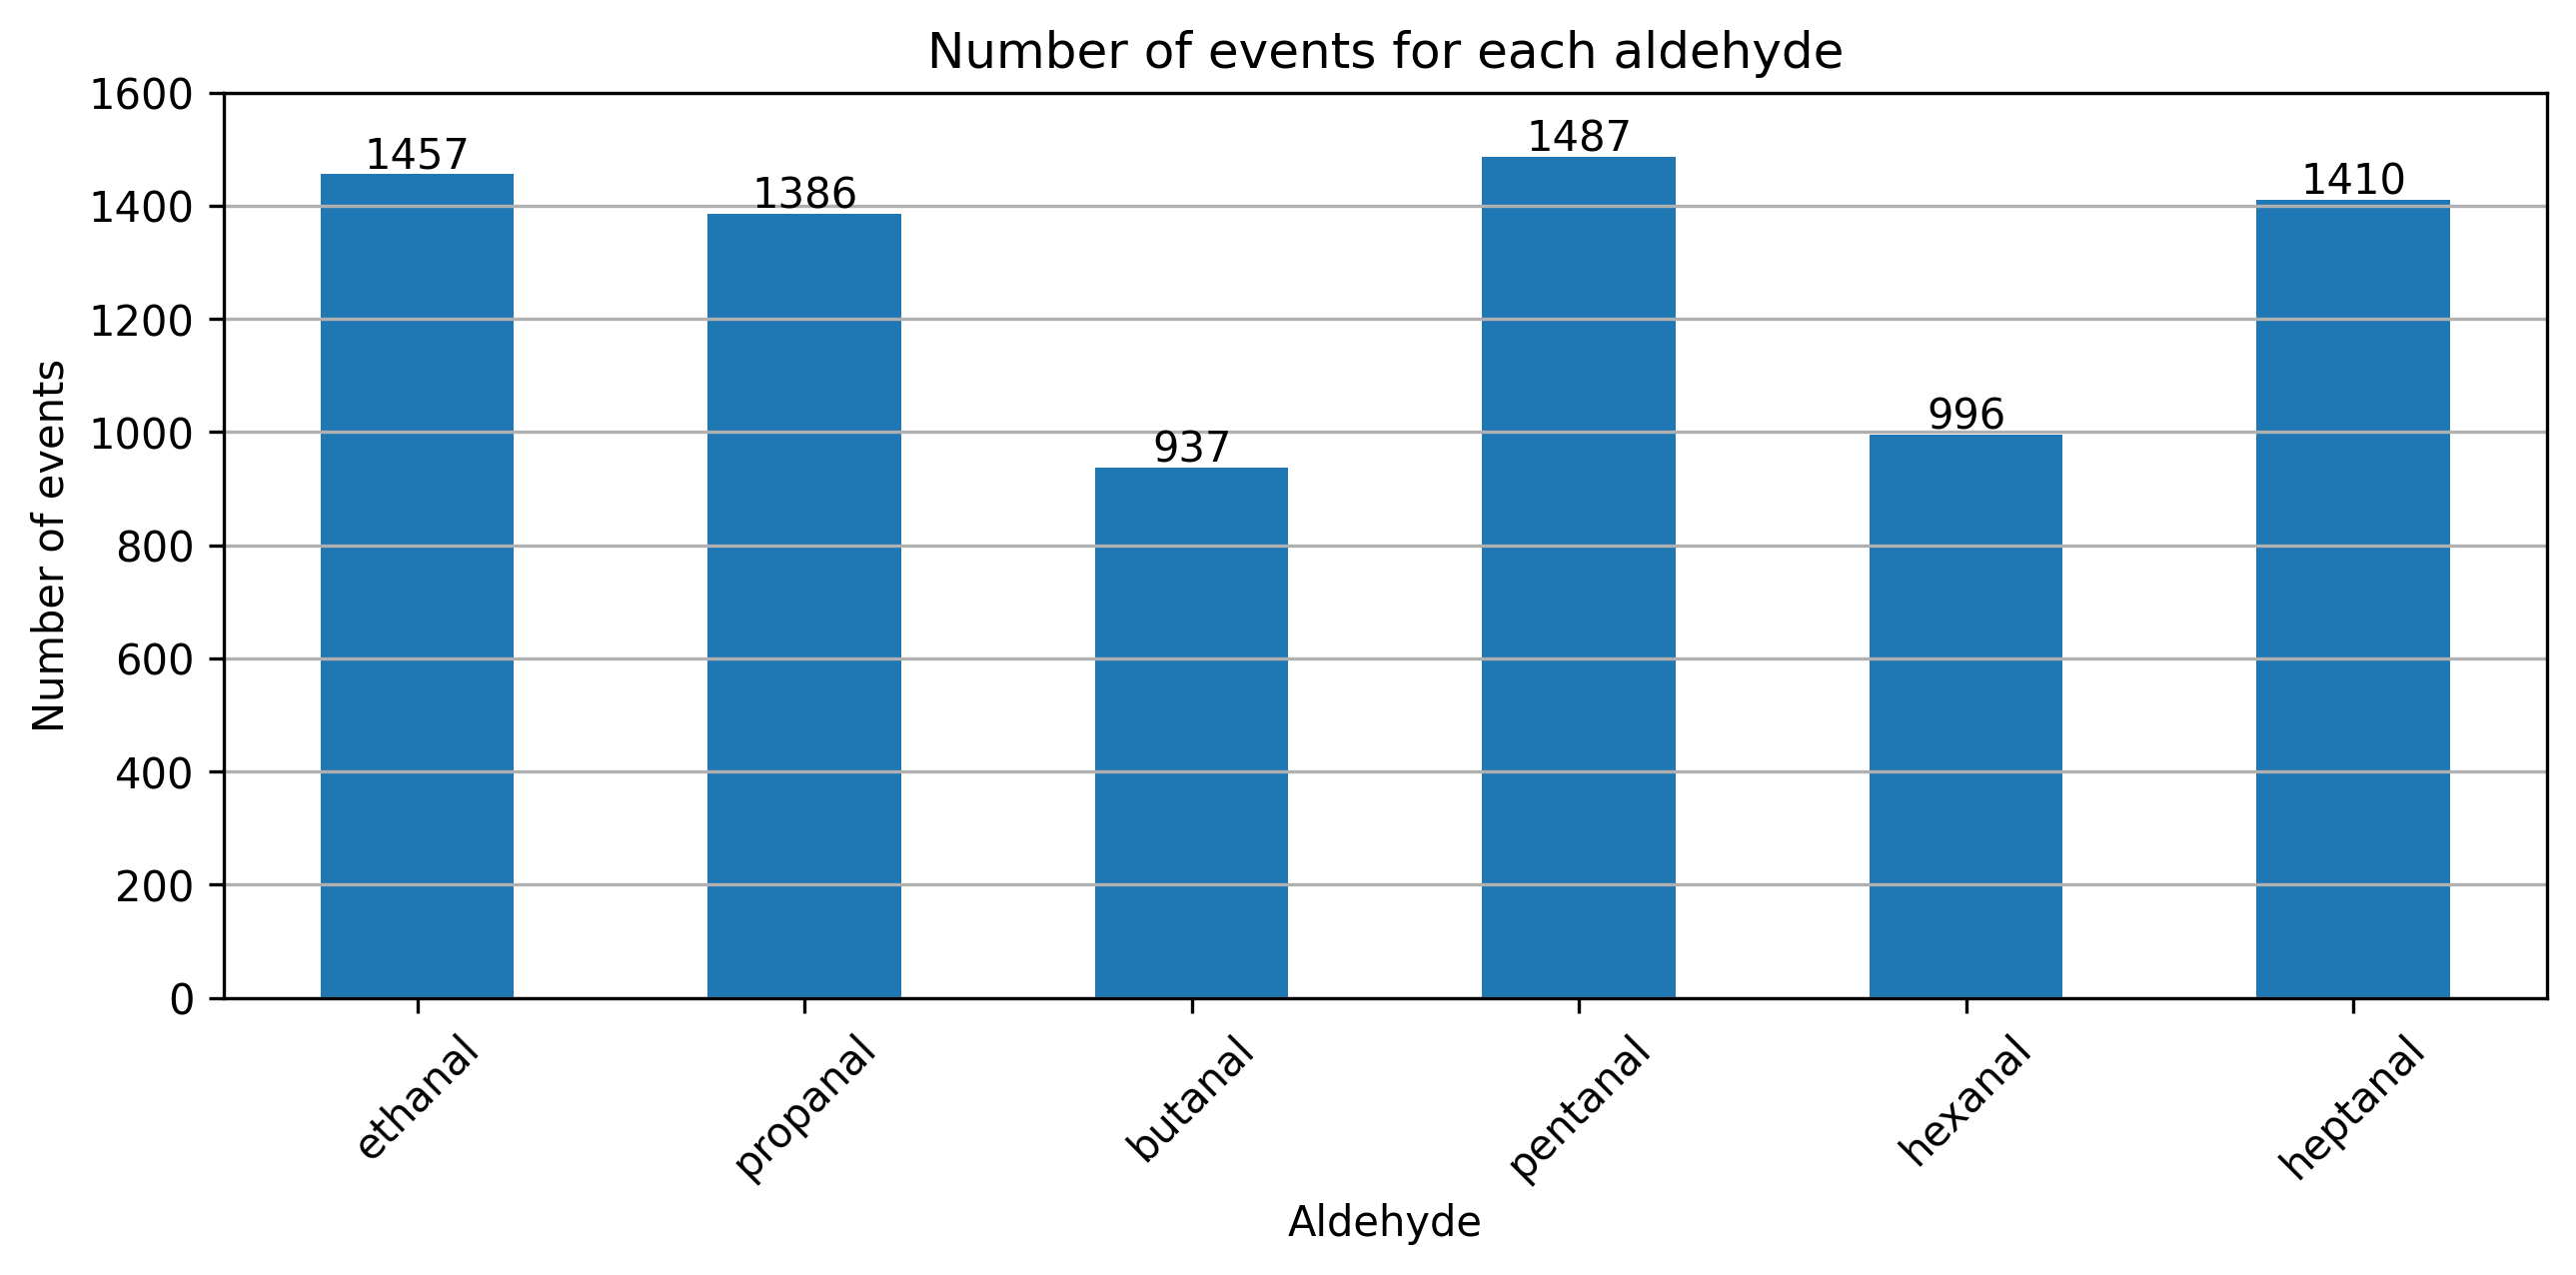

<Figure size 432x288 with 0 Axes>

In [3]:
label_class = ['ethanal', 'propanal', 'butanal', 'pentanal', 'hexanal', 'heptanal']

fig = plt.figure(figsize=(10, 4), dpi=300)
data['label'].value_counts().loc[label_class].plot(kind='bar')
for i, v in enumerate(data['label'].value_counts().loc[label_class]):
    plt.text(i, v + 10, str(v), ha='center')

plt.xlabel('Aldehyde')
plt.ylabel('Number of events')
plt.title('Number of events for each aldehyde')
plt.ylim(0, 1600)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
plt.savefig('fig_events_per_aldehyde.png')

# Feature selection

First we perform a random shuffle of the data, then we split the data into training and validation data.

In [4]:
labeled_data = shuffle(data,random_state = random_seed)

Then we get label and remove it from the training dataset.

In [5]:
label = labeled_data.label
features = labeled_data.drop('label', axis=1)

Select the features to be used in the model.

In [6]:
features_train = features.copy()
features_to_use = ['current_rmse', 'duration', 'i_res_median']
features_train = features_train[features_to_use]
features_train

,current_rmse,duration,i_res_median
7152,0.269852,337.468800,0.954962
3333,0.229042,176.882800,0.981102
5729,0.243404,649.531200,0.964330
5963,0.254503,100.343700,0.962081
1731,0.114155,7.281200,0.988080
...,...,...,...
5226,0.185054,91.765600,0.968248
5390,0.343538,350.125000,0.963404
860,0.366501,7.799805,0.993101
7603,0.240553,99.500000,0.953325


# Train test split
Split training set (70%) and testing set (30%) from labeled data.

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(features_train, label, test_size=0.3, random_state=random_seed, stratify=label)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

# save the training and testing set
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
Y_train.to_csv('Y_train.csv')
Y_test.to_csv('Y_test.csv')

(5371, 3) (2302, 3) (5371,) (2302,)


Then we standardize the data in training set and the standardization scaler of training set is uesd to transform the testing set

In [8]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Machine learning model 

## k nearest neighbors

/Users/allybo/opt/anaconda3/envs/MLChemistry/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/allybo/opt/anaconda3/envs/MLChemistry/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

{'n_neighbors': 3}
0.9707690390646093


/Users/allybo/opt/anaconda3/envs/MLChemistry/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/allybo/opt/anaconda3/envs/MLChemistry/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

Random Forest model accuracy:0.9665508253692441


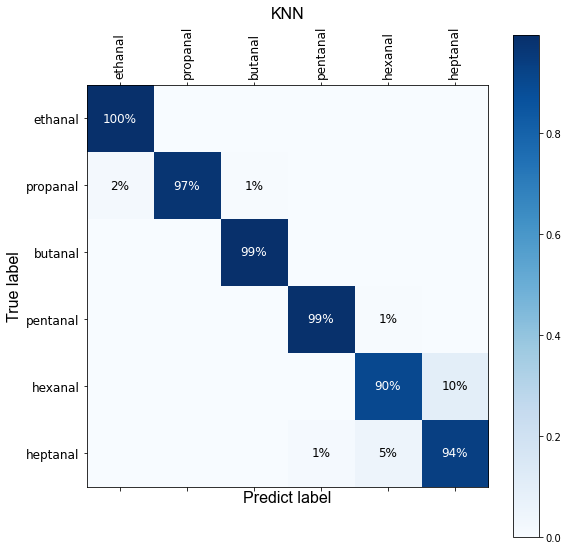

In [9]:
##KNN with grid search hyperparameter tuning
clf_knn = KNeighborsClassifier()
k_range = list(range(1, 20, 2))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(clf_knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, Y_train)
print(grid.best_params_)
print(grid.best_score_)

#best KNN model
clf_knn = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])

#model training and 10-fold cross-validation
clf_knn.fit(X_train,Y_train)
cv_scores_knn = cross_val_score(clf_knn, X_train, Y_train, cv=10, scoring='accuracy')
cv_scores_knn_mean = cv_scores_knn.mean() 

# evaluate the model on the testing set
title = 'KNN'
model = clf_knn
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
test_accuracy_knn = np.mean(prediction == Y_test)
print("Random Forest model accuracy:{}".format(test_accuracy_knn))
data_matrix = confusion_matrix(Y_test, prediction, labels=label_class)
data_Matrix = pd.DataFrame(data_matrix)
data_Matrix.columns=label_class
data_Matrix.index = label_class
Data_Matrix = (data_Matrix.T / np.sum(data_Matrix, 1)).T

#plot the confusion matrix
plt.rc('figure',figsize=(9,9))
plt.matshow(Data_Matrix, cmap=plt.cm.Blues)  
plt.title(title,font1)
plt.colorbar()  
tick_marks = np.arange(len(label_class))
plt.xticks(tick_marks, label_class,fontsize=12, rotation=90)
plt.yticks(tick_marks, label_class,fontsize=12)
plt.ylabel('True label',font1)
plt.xlabel('Predict label',font1)
for x in range(len(data_matrix)):
    for y in range(len(data_matrix)):
        a = np.sum(data_matrix[x,:])
        number = data_matrix[x,y]/a*100
        if round(number)>0:
            if x == y:
                plt.annotate(str(round(number)) + '%', xy = (y,x), horizontalalignment = 'center', verticalalignment = 'center',color = 'White',fontsize=12)
            else:
                plt.annotate(str(round(number)) + '%', xy = (y,x), horizontalalignment = 'center', verticalalignment = 'center',color = 'Black',fontsize=12)
plt.savefig('fig_confusion_matrix_knn.png', dpi=300)
plt.show()

## Decision tree

{'max_depth': 6}
0.9748644887956635
Decision tree mean 10-fold cross validation accuracy:0.9748644887956635
Decision Tree model accuracy:0.9748045178105995


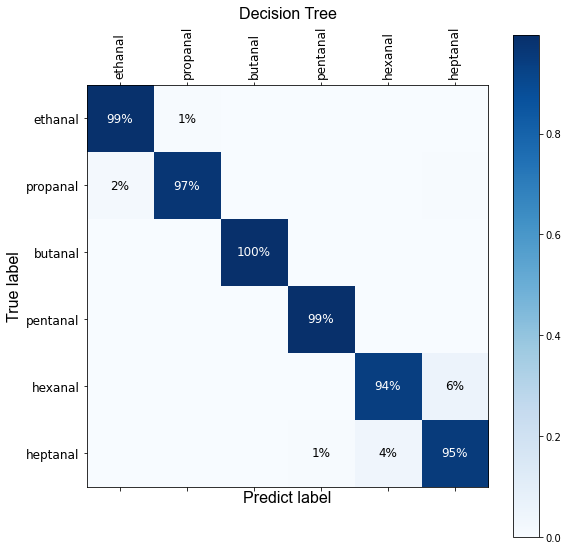

In [10]:
##Decision Tree with grid search hyperparameter tuning
clf_DeciTree = DecisionTreeClassifier(random_state=random_seed)
param_grid = {'max_depth': np.arange(3, 10)}
grid = GridSearchCV(clf_DeciTree, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, Y_train)
print(grid.best_params_)
print(grid.best_score_)

#best Decision Tree model
clf_DeciTree = DecisionTreeClassifier(max_depth=grid.best_params_['max_depth'], random_state=random_seed)

#model training and 10-fold cross-validation
clf_DeciTree.fit(X_train,Y_train)
cv_scores_DeciTree = cross_val_score(clf_DeciTree, X_train, Y_train, cv=10, scoring='accuracy')
cv_scores_DeciTree_mean = cv_scores_DeciTree.mean() # 10-fold cross-validation
print("Decision tree mean 10-fold cross validation accuracy:{}".format(cv_scores_DeciTree_mean))

# evaluate the model on the testing set
title = 'Decision Tree'
model = clf_DeciTree
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
test_accuracy_DeciTree = np.mean(prediction == Y_test)
print("Decision Tree model accuracy:{}".format(test_accuracy_DeciTree))
data_matrix = confusion_matrix(Y_test, prediction, labels=label_class)
data_Matrix = pd.DataFrame(data_matrix)
data_Matrix.columns=label_class
data_Matrix.index = label_class
Data_Matrix = (data_Matrix.T / np.sum(data_Matrix, 1)).T

#plot the confusion matrix
plt.rc('figure',figsize=(9,9))
plt.matshow(Data_Matrix, cmap=plt.cm.Blues)  
plt.title(title,font1)
plt.colorbar()  
tick_marks = np.arange(len(label_class))
plt.xticks(tick_marks, label_class,fontsize=12, rotation=90)
plt.yticks(tick_marks, label_class,fontsize=12)
plt.ylabel('True label',font1)
plt.xlabel('Predict label',font1)
for x in range(len(data_matrix)):
    for y in range(len(data_matrix)):
        a = np.sum(data_matrix[x,:])
        number = data_matrix[x,y]/a*100
        if round(number)>0:
            if x == y:
                plt.annotate(str(round(number)) + '%', xy = (y,x), horizontalalignment = 'center', verticalalignment = 'center',color = 'White',fontsize=12)
            else:
                plt.annotate(str(round(number)) + '%', xy = (y,x), horizontalalignment = 'center', verticalalignment = 'center',color = 'Black',fontsize=12)
plt.savefig('fig_confusion_matrix_Decision_Tree.png', dpi=300)
plt.show()

## Support Vector Machine

{'C': 1000, 'gamma': 0.1}
0.9761680269707101
SVM mean 10-fold cross validation accuracy:0.9761680269707101
SVM model accuracy:0.9748045178105995


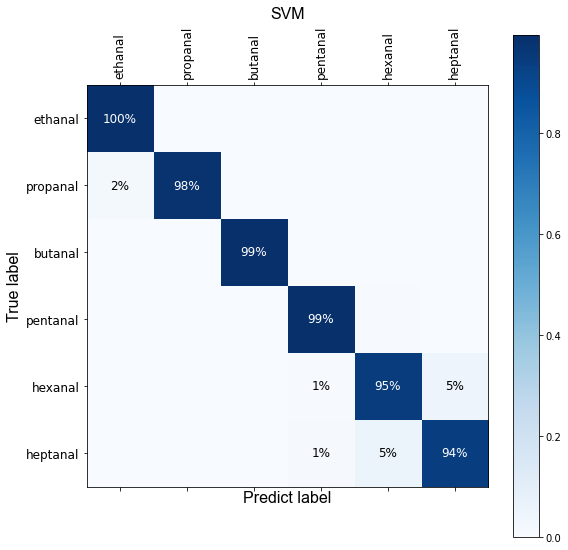

In [11]:
##SVM with grid search hyperparameter tuning
clf_svm = sklearn.svm.SVC()
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
grid = GridSearchCV(clf_svm, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, Y_train)
print(grid.best_params_)
print(grid.best_score_)
#best SVM model
clf_svm = sklearn.svm.SVC(C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])

#model training and 10-fold cross-validation
clf_svm .fit(X_train, Y_train)
cv_scores_svm = cross_val_score(clf_svm, X_train, Y_train, cv=10, scoring='accuracy')
cv_scores_svm_mean = cv_scores_svm.mean()  # 10-fold cross-validation
print("SVM mean 10-fold cross validation accuracy:{}".format(cv_scores_svm_mean))

# evaluate the model on the testing set
title = 'SVM'
model = clf_svm
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
test_accuracy_svm = np.mean(prediction == Y_test)
print("SVM model accuracy:{}".format(test_accuracy_svm))
data_matrix = confusion_matrix(Y_test, prediction, labels=label_class)
data_Matrix = pd.DataFrame(data_matrix)
data_Matrix.columns=label_class
data_Matrix.index = label_class
Data_Matrix = (data_Matrix.T / np.sum(data_Matrix, 1)).T

#plot the confusion matrix
plt.rc('figure',figsize=(9,9))
plt.matshow(Data_Matrix, cmap=plt.cm.Blues)  
plt.title(title,font1)
plt.colorbar()  
tick_marks = np.arange(len(label_class))
plt.xticks(tick_marks, label_class,fontsize=12, rotation=90)
plt.yticks(tick_marks, label_class,fontsize=12)
plt.ylabel('True label',font1)
plt.xlabel('Predict label',font1)
for x in range(len(data_matrix)):
    for y in range(len(data_matrix)):
        a = np.sum(data_matrix[x,:])
        number = data_matrix[x,y]/a*100
        if round(number)>0:
            if x == y:
                plt.annotate(str(round(number)) + '%', xy = (y,x), horizontalalignment = 'center', verticalalignment = 'center',color = 'White',fontsize=12)
            else:
                plt.annotate(str(round(number)) + '%', xy = (y,x), horizontalalignment = 'center', verticalalignment = 'center',color = 'Black',fontsize=12)
plt.savefig('fig_confusion_matrix_SVM.png', dpi=300)
plt.show()

## Random Forest

{'n_estimators': 600}
0.9756104061528663
Random Forest mean 10-fold cross validation accuracy:0.9756104061528663
Random Forest model accuracy:0.9795829713292789


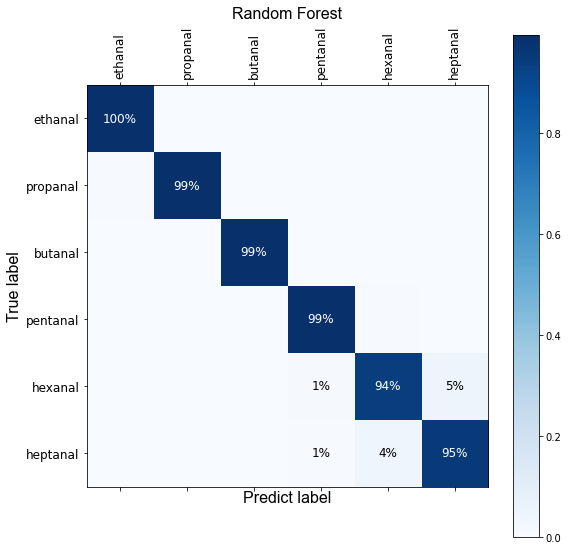

In [12]:
##Randomforest with grid search hyperparameter tuning
clf_RandomForest = RandomForestClassifier(random_state=random_seed, class_weight = "balanced")
param_grid = {'n_estimators': [400, 500, 600]}
grid = GridSearchCV(clf_RandomForest, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, Y_train)
print(grid.best_params_)
print(grid.best_score_)
#best Random Forest model
clf_RandomForest = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'], random_state=random_seed, class_weight = "balanced")

#model training and 10-fold cross-validation
clf_RandomForest.fit(X_train, Y_train)
pre_test = clf_RandomForest.predict(X_test)
cv_scores_RandomForest = cross_val_score(clf_RandomForest, X_train, Y_train, cv=10, scoring='accuracy')
cv_scores_RandomForest_mean = cv_scores_RandomForest.mean()
print("Random Forest mean 10-fold cross validation accuracy:{}".format(cv_scores_RandomForest_mean))

# evaluate the model on the testing set
title = 'Random Forest'
model = clf_RandomForest
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
test_accuracy_RandomForest = np.mean(prediction == Y_test)
print("Random Forest model accuracy:{}".format(test_accuracy_RandomForest))
data_matrix = confusion_matrix(Y_test, prediction, labels=label_class)
data_Matrix = pd.DataFrame(data_matrix)
data_Matrix.columns=label_class
data_Matrix.index = label_class
Data_Matrix = (data_Matrix.T / np.sum(data_Matrix, 1)).T

#plot the confusion matrix
plt.rc('figure',figsize=(9,9))
plt.matshow(Data_Matrix, cmap=plt.cm.Blues)  
plt.title(title,font1)
plt.colorbar()  
tick_marks = np.arange(len(label_class))
plt.xticks(tick_marks, label_class,fontsize=12, rotation=90)
plt.yticks(tick_marks, label_class,fontsize=12)
plt.ylabel('True label',font1)
plt.xlabel('Predict label',font1)
for x in range(len(data_matrix)):
    for y in range(len(data_matrix)):
        a = np.sum(data_matrix[x,:])
        number = data_matrix[x,y]/a*100
        if round(number)>0:
            if x == y:
                plt.annotate(str(round(number)) + '%', xy = (y,x), horizontalalignment = 'center', verticalalignment = 'center',color = 'White',fontsize=12)
            else:
                plt.annotate(str(round(number)) + '%', xy = (y,x), horizontalalignment = 'center', verticalalignment = 'center',color = 'Black',fontsize=12)
plt.savefig('fig_confusion_matrix_Random_Forest.png', dpi=300)
plt.show()

## Extra Trees

{'n_estimators': 400}
0.9741216866385607
Extra Trees mean 10-fold cross validation accuracy:0.9741216866385607
Extra Trees model accuracy:0.9739357080799305


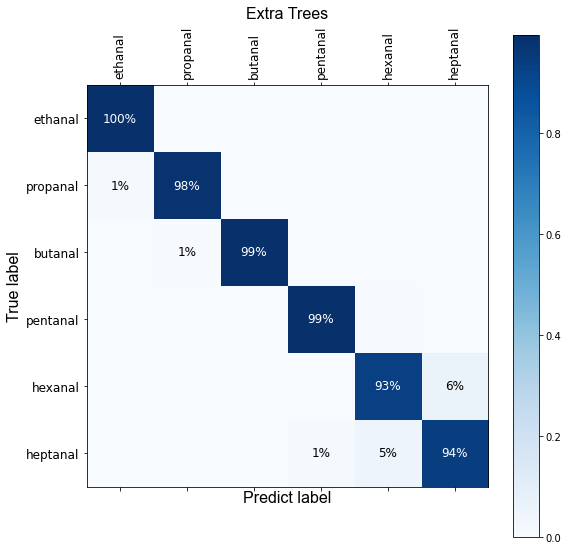

In [13]:
##ExtraTrees with grid search hyperparameter tuning
clf_ExtraTrees = ExtraTreesClassifier(random_state=random_seed)
param_grid = {'n_estimators': [400, 500, 600]}
grid = GridSearchCV(clf_ExtraTrees, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, Y_train)
print(grid.best_params_)
print(grid.best_score_)
#best Extra Trees model
clf_ExtraTrees = ExtraTreesClassifier(n_estimators=grid.best_params_['n_estimators'], random_state=random_seed)

#model training and 10-fold cross-validation
clf_ExtraTrees.fit(X_train, Y_train)
cv_scores_et = cross_val_score(clf_ExtraTrees, X_train, Y_train, cv=10, scoring='accuracy')
cv_scores_et_mean = cv_scores_et.mean()
print("Extra Trees mean 10-fold cross validation accuracy:{}".format(cv_scores_et_mean))

# evaluate the model on the testing set
title = 'Extra Trees'
model = clf_ExtraTrees
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
test_accuracy_et = np.mean(prediction == Y_test)
print("Extra Trees model accuracy:{}".format(test_accuracy_et))
data_matrix = confusion_matrix(Y_test, prediction, labels=label_class)
data_Matrix = pd.DataFrame(data_matrix)
data_Matrix.columns=label_class
data_Matrix.index = label_class
Data_Matrix = (data_Matrix.T / np.sum(data_Matrix, 1)).T

#plot the confusion matrix
plt.rc('figure',figsize=(9,9))
plt.matshow(Data_Matrix, cmap=plt.cm.Blues)
plt.title(title,font1)
plt.colorbar()
tick_marks = np.arange(len(label_class))
plt.xticks(tick_marks, label_class,fontsize=12, rotation=90)
plt.yticks(tick_marks, label_class,fontsize=12)
plt.ylabel('True label',font1)
plt.xlabel('Predict label',font1)
for x in range(len(data_matrix)):
    for y in range(len(data_matrix)):
        a = np.sum(data_matrix[x,:])
        number = data_matrix[x,y]/a*100
        if round(number)>0:
            if x == y:
                plt.annotate(str(round(number)) + '%', xy = (y,x), horizontalalignment = 'center', verticalalignment = 'center',color = 'White',fontsize=12)
            else:
                plt.annotate(str(round(number)) + '%', xy = (y,x), horizontalalignment = 'center', verticalalignment = 'center',color = 'Black',fontsize=12)
plt.savefig('fig_confusion_matrix_Extra_Trees.png', dpi=300)
plt.show()

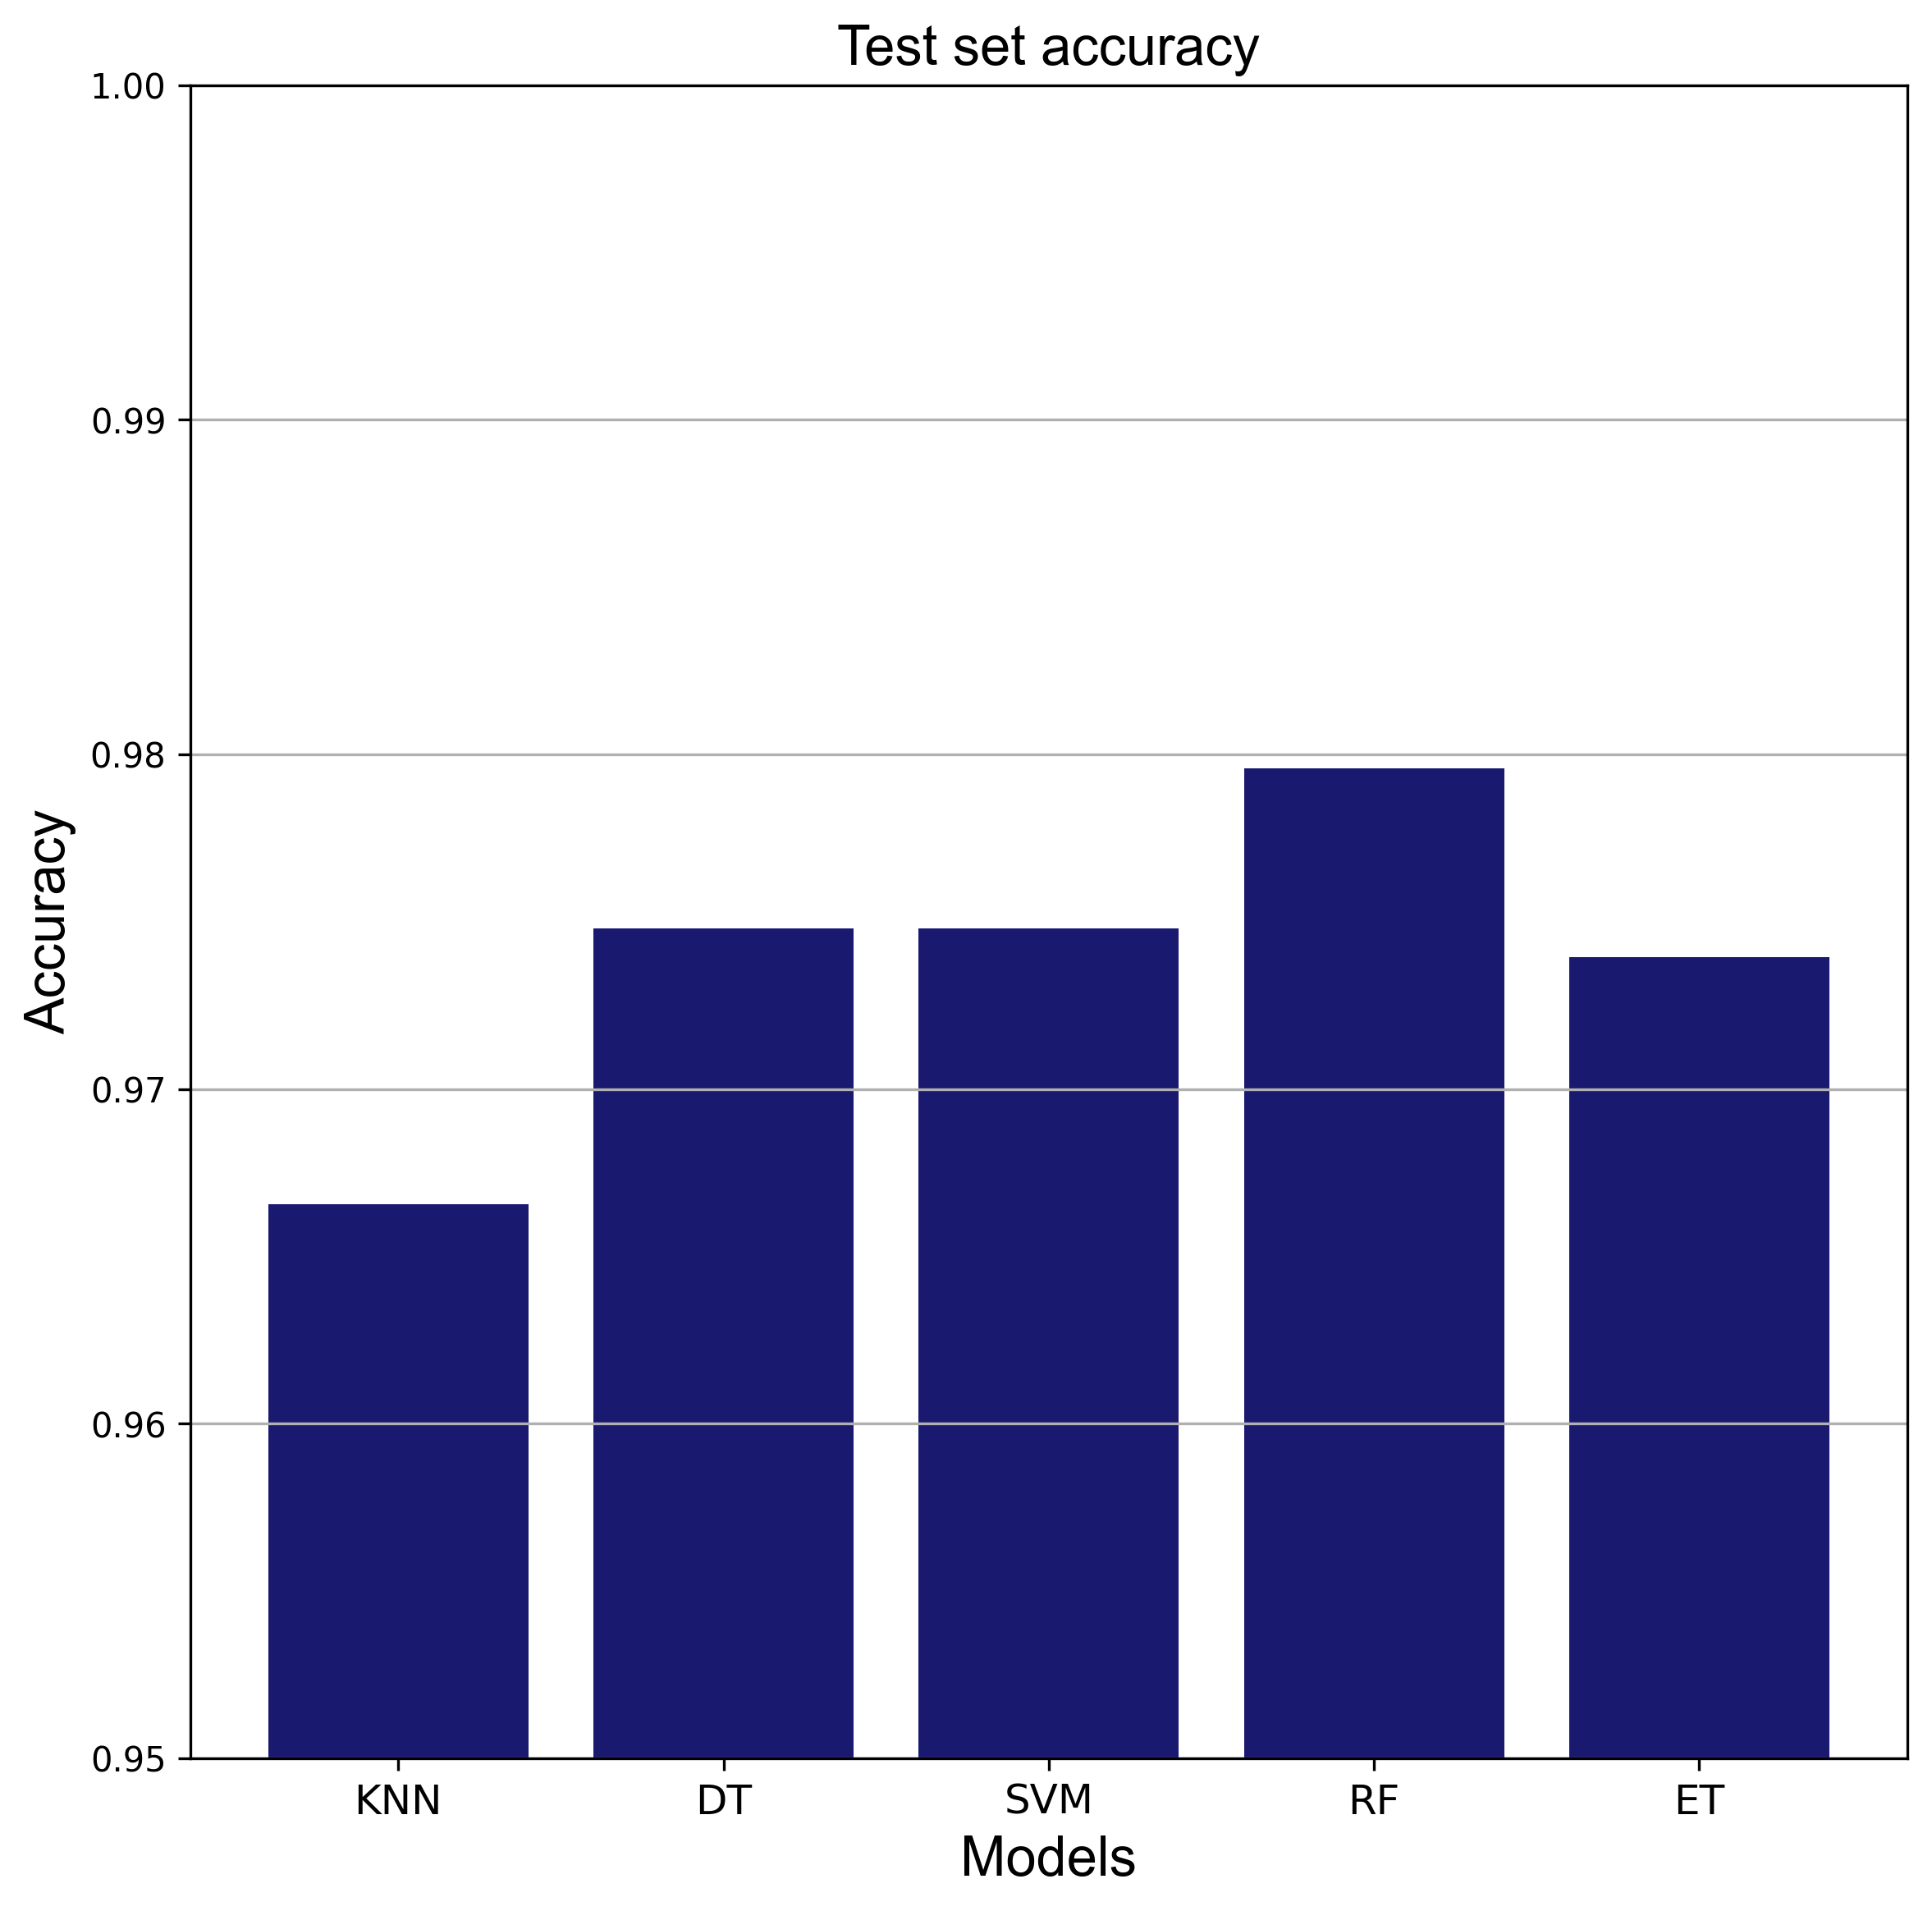

In [14]:
# collect all test accuracy as a list and plot the bar chart
models = ['KNN', 'DT', 'SVM', 'RF', 'ET']
clfs = [clf_knn, clf_DeciTree, clf_svm, clf_RandomForest, clf_ExtraTrees]
accuracy = [test_accuracy_knn, test_accuracy_DeciTree, test_accuracy_svm, test_accuracy_RandomForest, test_accuracy_et]
fig = plt.figure(figsize=(9,9), dpi=300)
plt.bar(models, accuracy, color='midnightblue')
plt.ylim(0.95, 1)
plt.grid(axis='y')
plt.xlabel('Models', font1)
plt.ylabel('Accuracy', font1)
plt.xticks(fontsize=12, rotation=0)
plt.title('Test set accuracy', font1)
plt.savefig('fig_models_test_accuracy.png')

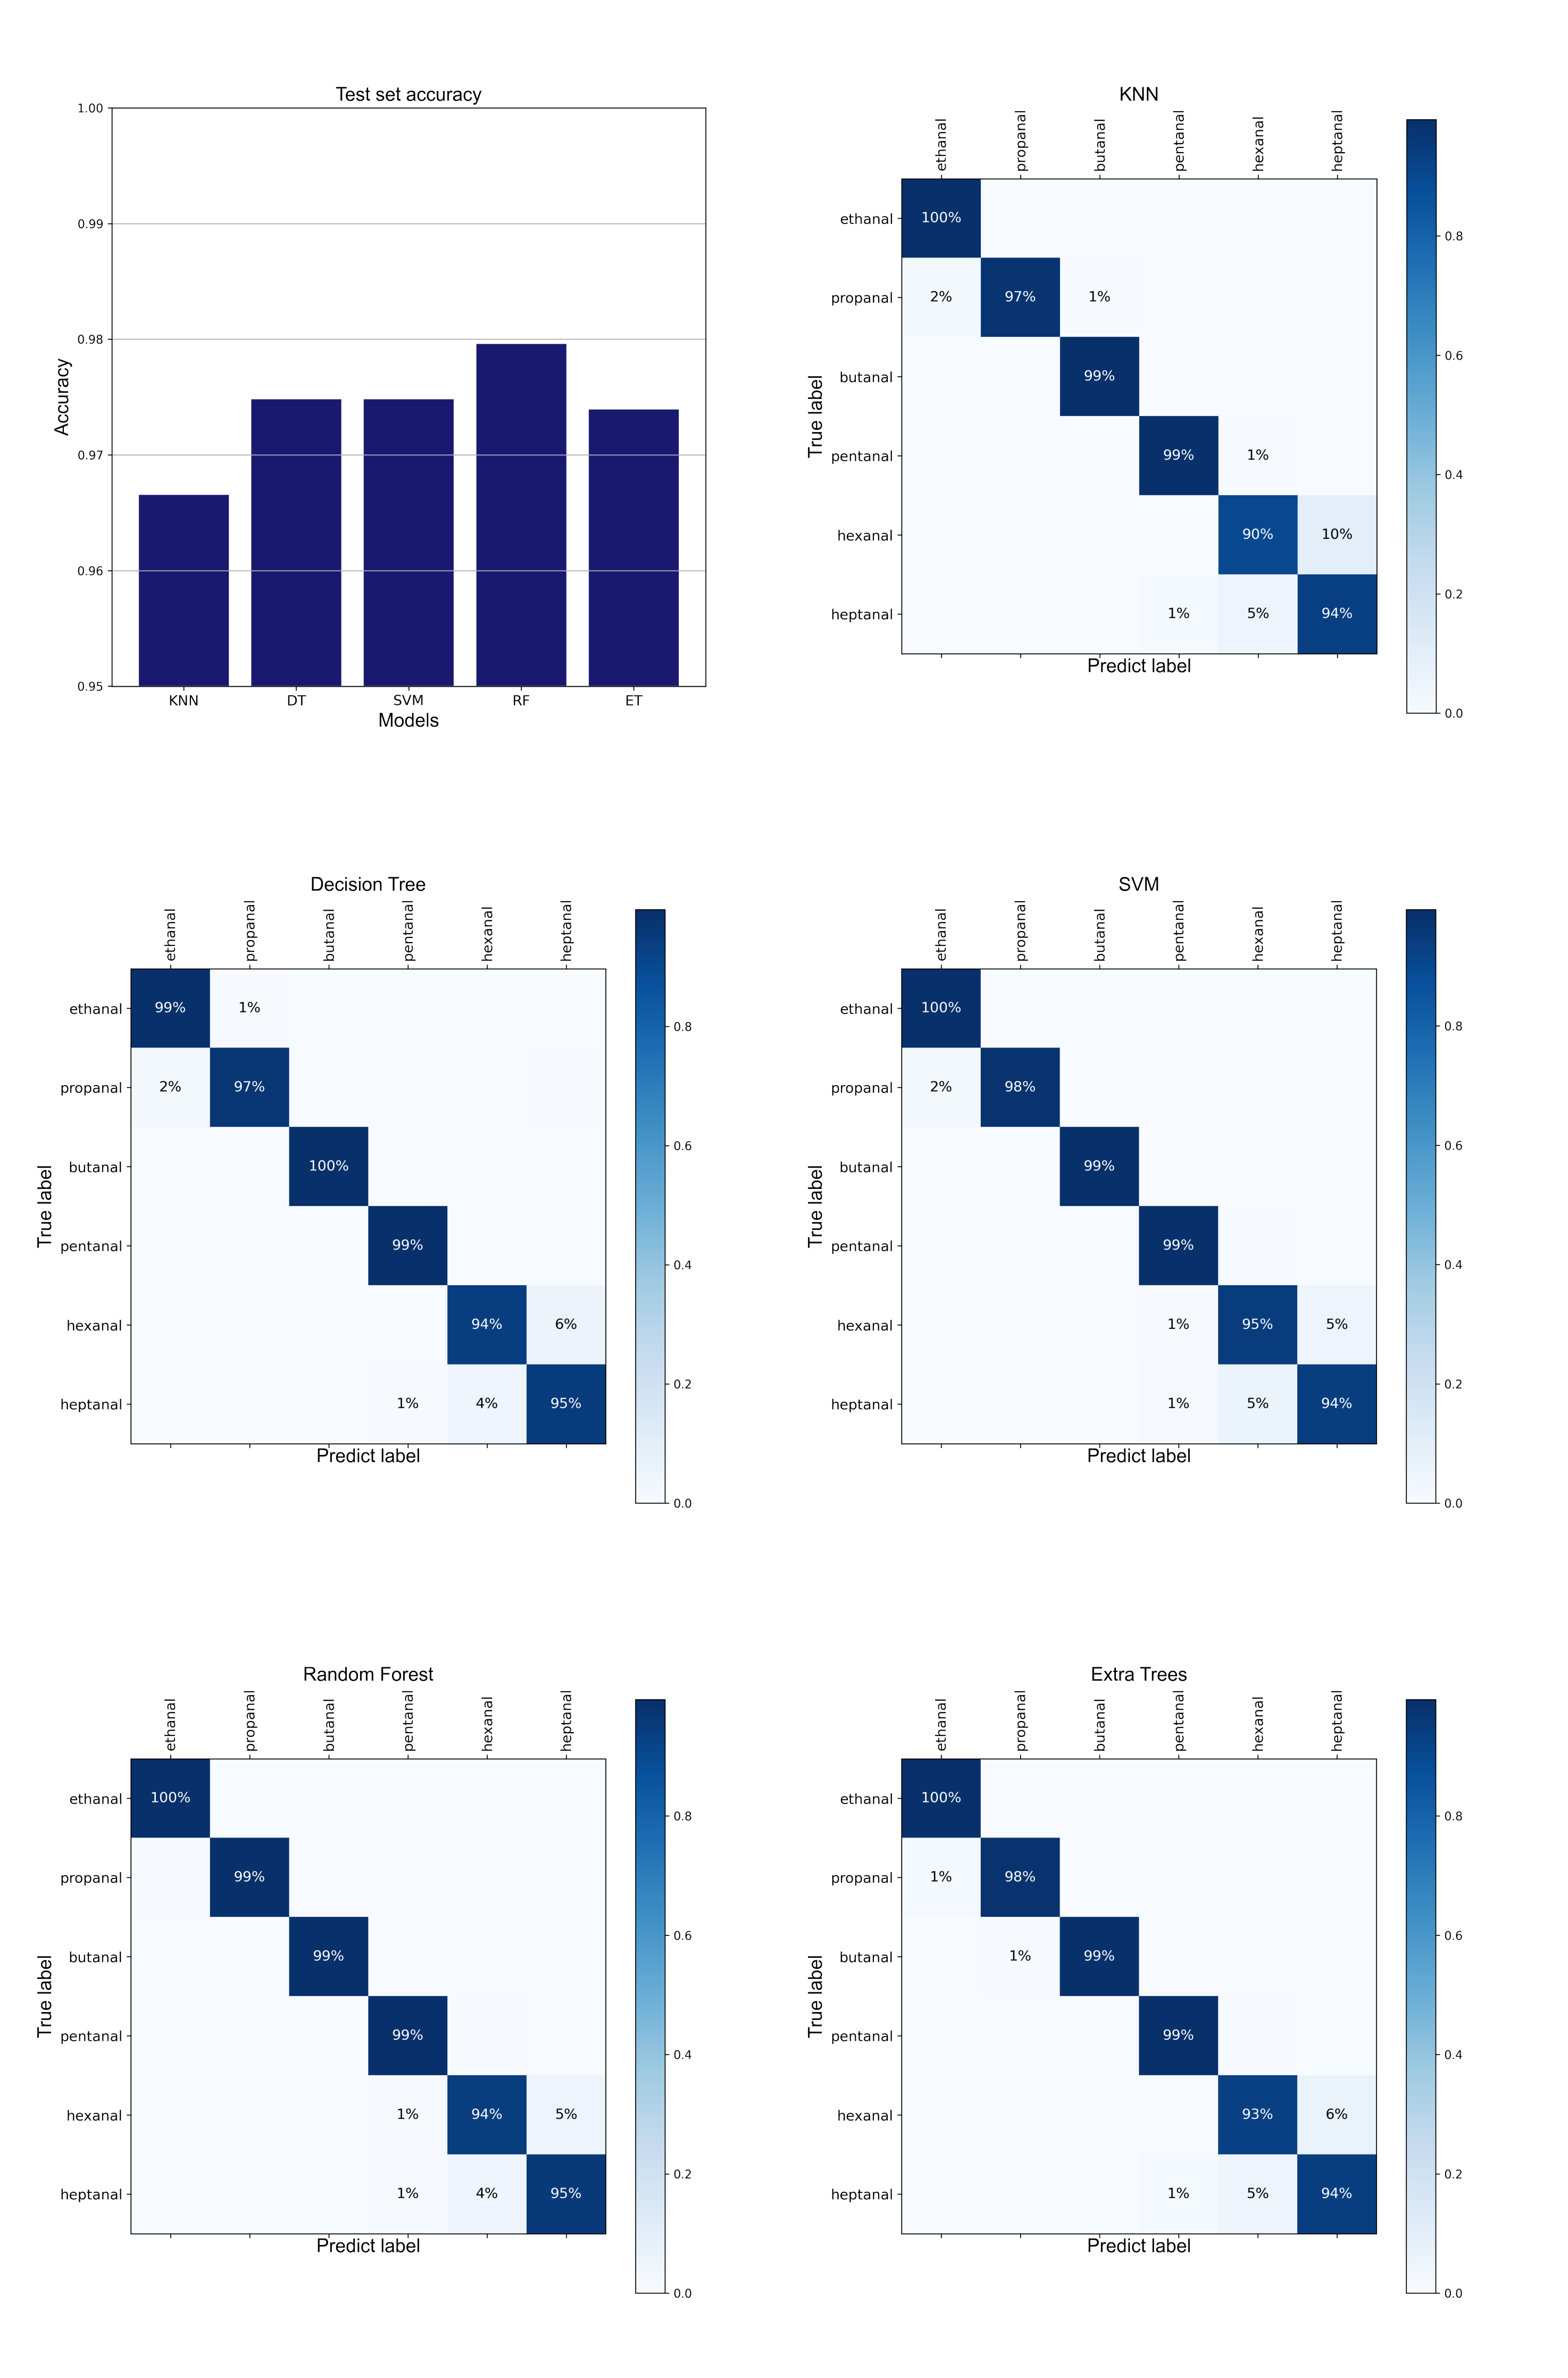

In [15]:
# collect all PNG files and show them in one figure
png_files = ['fig_models_test_accuracy.png',
             'fig_confusion_matrix_knn.png', 
             'fig_confusion_matrix_Decision_Tree.png', 
             'fig_confusion_matrix_SVM.png', 
             'fig_confusion_matrix_Random_Forest.png',
             'fig_confusion_matrix_Extra_Trees.png'
             ]
fig = plt.figure(figsize=(10, 15), dpi=300)
for i, png_file in enumerate(png_files):
    img = plt.imread(png_file)
    plt.subplot(3, 2, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.savefig('fig_summary.png')
plt.show()